<a href="https://colab.research.google.com/github/Tasmia062/Papaya-Leaf/blob/main/Papaya_Disease_Detection_EfficientNet_B3_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Must download the dataset! Change the directory path as well.

Dataset Link: -----

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the paths to your augmented dataset directory in Google Drive
augmented_data_dir = '/content/drive/MyDrive/Augmented Dataset'

In [ ]:
pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.8 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from efficientnet.tfkeras import EfficientNetB3

In [ ]:
# Define parameters
image_height, image_width = 224, 224
batch_size = 32
num_classes = 6
epochs = 50

In [ ]:
# Load and preprocess data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)  # 80% for training, 20% for validation

train_generator = train_datagen.flow_from_directory(
    augmented_data_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')  # specify training subset

validation_generator = train_datagen.flow_from_directory(
    augmented_data_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')  # specify validation subset

Found 5299 images belonging to 6 classes.
Found 1320 images belonging to 6 classes.


In [ ]:
# Load the EfficientNetB3 model without the top layer:
base_model = EfficientNetB3(input_shape=(224,224,3), include_top=False, weights='imagenet')

44107200/44107200 [==============================] - 0s 0us/step


In [ ]:
# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Create a Sequential model
x = base_model.output
x = Dropout(0.3)(x)
x = GlobalAveragePooling2D()(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Compile the model:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Step 6: Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,  # Adjust as needed
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/50
165/165 [==============================] - 3645s 22s/step - loss: 0.9938 - accuracy: 0.6660 - val_loss: 0.6370 - val_accuracy: 0.8285
Epoch 2/50
165/165 [==============================] - 38s 229ms/step - loss: 0.5640 - accuracy: 0.8384 - val_loss: 0.4275 - val_accuracy: 0.8986
Epoch 3/50
165/165 [==============================] - 37s 226ms/step - loss: 0.4318 - accuracy: 0.8804 - val_loss: 0.3342 - val_accuracy: 0.9253
Epoch 4/50
165/165 [==============================] - 38s 230ms/step - loss: 0.3626 - accuracy: 0.9037 - val_loss: 0.2728 - val_accuracy: 0.9383
Epoch 5/50
165/165 [==============================] - 38s 230ms/step - loss: 0.3220 - accuracy: 0.9163 - val_loss: 0.2568 - val_accuracy: 0.9398
Epoch 6/50
165/165 [==============================] - 41s 249ms/step - loss: 0.2844 - accuracy: 0.9218 - val_loss: 0.2148 - val_accuracy: 0.9543
Epoch 7/50
165/165 [==============================] - 38s 228ms/step - loss: 0.2646 - accuracy: 0.9273 - val_loss: 0.1971 - val_ac

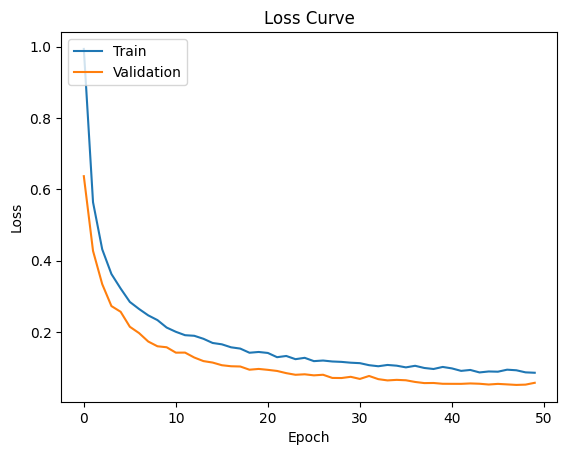

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss Curve')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_training_history(history)

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

42/42 [==============================] - 9s 206ms/step - loss: 0.0574 - accuracy: 0.9841
Validation Loss: 0.057382311671972275, Validation Accuracy: 0.9840909242630005


In [ ]:
# Display model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 40)         1080      ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 40)         160       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 112, 112, 40)         0         ['stem_bn[0][0]']         

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/Papaya Leaf/papaya_model_efficientnetB3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the model
model = load_model('papaya_model_efficientnetB3.h5')

# Define the class labels based on your training setup
class_labels = ['Healthy Leaf', 'Leaf Curl', 'Mealybug', 'Mite', 'Mosaic', 'Ringspot']

# Load an image for testing
img_path = '/content/drive/MyDrive/Papaya Leaf/asp_car2.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the image

# Make predictions
predictions = model.predict(img_array)

# Get the class with the highest probability
predicted_class = np.argmax(predictions)
predicted_class_name = class_labels[predicted_class]

print(f"The predicted class is: {predicted_class_name} (Class Number: {predicted_class+1})")


OSError: No file or directory found at papaya_model_efficientnetB3.h5